https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

http://www.nervanasys.com/demystifying-deep-reinforcement-learning/

In [107]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import numpy as np
import random
import tensorflow as tf
from itertools import count
from collections import deque
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import time as timelib
from scipy import signal
from IPython import display
import os

In [109]:
startPath = os.getcwd()

In [110]:
# Learning parameters
minibatch_size = 32 # 32 suggested in DeepMind Nature paper
episode_max = 5000
tepisode_max = 20
random_action_probability = 1 # initial value of e in e-greedy exploration - 0.9
target_reset = 10000 # Deepmind used 10000
max_experience = 100000
exploration_period = max_experience #max_experience/40
controlbatch = 1
learnrate = 0.0025 # Deepmind used 0.00025
randomTC = 10000 # 1000000 for nice and slow
gradientmomentum = 0.95
randommax = 1 #20/controlbatch # multiplied by controlbatch
emin = 0.05 # 5% of the time

In [111]:
# Simulation parameters
dt = 0.05

In [112]:
# Plot parameters
plot_every = 1

In [113]:
# Model parameters
L1 = 1.0
L2 = 1.0
M1 = 1.0
M2 = 1.0
model_K = 1
model_C = 1
model_f = 0.05
model_Dem = 1.0
G = 9.81

In [114]:
ops.reset_default_graph()
session = tf.InteractiveSession()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1105ed050>> ignored


In [115]:
# TensorFlow configuration
optimizer = tf.train.RMSPropOptimizer(learning_rate=learnrate)

We instead use an architecture in which there is a separate output unit for each possible action, and only the state representation is an input to the neural network. The outputs correspond to the predicted Q-values of the individual actions for the input state. The main advantage of this type of architecture is the ability to compute Q-values for all possible actions in a given state with only a single forward pass through the network.

In [116]:
# Network
observation_ind = 3
observation_size = observation_ind*controlbatch
output_size = 21
hidden1_size = 50
hidden2_size = 50
observation = tf.placeholder(tf.float32, (None, observation_size), name="observation")
next_observation = tf.placeholder(tf.float32, (None, observation_size), name="next_observation")

with tf.name_scope("Live") as scope:
    
    Layer1 = tf.Variable(tf.random_normal([observation_size, hidden1_size], stddev=0.1, mean=0.1),name="Layer1")
    Layer2 = tf.Variable(tf.random_normal([hidden1_size, hidden2_size], stddev=0.1, mean=0.1),name="Layer2")
    Layer3 = tf.Variable(tf.random_normal([hidden2_size, output_size], stddev=0.1, mean=0.1),name="Layer3")

    y1 = tf.nn.tanh(tf.matmul(observation, Layer1))
    y2 = tf.nn.tanh(tf.matmul(y1, Layer2))
    action_scores = tf.matmul(y2, Layer3)
    
    action_scores_max = tf.reduce_max(action_scores)
    action_scores_max_summary = tf.scalar_summary("action_scores max", action_scores_max)
    
    predicted_actions = tf.argmax(action_scores, dimension=1, name="predicted_actions")

with tf.name_scope("Frozen") as scope:
    
    TLayer1 = tf.Variable(Layer1.initialized_value(),name="TLayer1")
    TLayer2 = tf.Variable(Layer2.initialized_value(),name="TLayer2")
    TLayer3 = tf.Variable(Layer3.initialized_value(),name="TLayer3")

    Ty1 = tf.nn.tanh(tf.matmul(next_observation, TLayer1))
    Ty2 = tf.nn.tanh(tf.matmul(Ty1, TLayer2))
    Taction_scores = tf.matmul(Ty2, TLayer3)

    Tpredicted_actions = tf.argmax(Taction_scores, dimension=1, name="predicted_actions")

In [117]:
# Control parameters
Cmax = 3
C = np.linspace(-Cmax,Cmax,output_size)

In [118]:
# Training:  Placeholders
action_mask = tf.placeholder(tf.float32, (None, output_size), name="action_mask")
rewards = tf.placeholder(tf.float32, (minibatch_size,), name="rewards")
next_observation_mask = tf.placeholder(tf.float32, (None,), name="next_observation_mask")
discount_rate = tf.to_float(tf.Variable(0.99))

In [119]:
# Training: Current
masked_action_scores = tf.reduce_sum(action_scores * action_mask, reduction_indices=[1,])

#split0, split1, split2 = tf.split(1, output_size, action_scores)

#tf.gather(output_size,[[0][0]])

In [120]:
# Training: Future
next_action_scores = tf.to_float(tf.stop_gradient(Taction_scores)) # Break tensor chain
target_values = tf.reduce_max(next_action_scores, reduction_indices=[1,]) # Maximum predicted future reward
future_rewards = rewards + discount_rate * target_values

In [121]:
# Target Functions
copy_L1 = TLayer1.assign(Layer1)
copy_L2 = TLayer2.assign(Layer2)
copy_L3 = TLayer3.assign(Layer3)

In [122]:
# Training: Optimisation
with tf.name_scope("optimize") as scope:
    #temp_diff = tf.clip_by_value((masked_action_scores - future_rewards), -1, 1) # Clipped to -1 and 1
    temp_diff = (masked_action_scores - future_rewards)
    prediction_error = tf.square(temp_diff)
    
    mean_prediction_error = tf.reduce_mean(prediction_error)
    mpe = tf.scalar_summary("mean_prediction_error", mean_prediction_error)
    
    train_op = optimizer.minimize(prediction_error)
    
    # Clipped gradient optimization function
    gradients = optimizer.compute_gradients(prediction_error)
    #for i, (grad, var) in enumerate(gradients):
    #    if grad is not None:
    #        gradients[i] = (grad, var)
            #gradients[i] = (tf.clip_by_norm(grad, 5), var)
    
    #train_op = optimizer.apply_gradients(gradients)

In [124]:
# Writer
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/Users/davidbrowne/tensorflowlogs/", session.graph_def)

In [125]:
# Initialisation
session.run(tf.initialize_all_variables())

Following previous approaches to playing Atari 2600 games, we also use a simple frame-skipping technique. More precisely, the agent sees and selects actions on every kth frame instead of every frame, and its last action is repeated on skipped frames.

In [126]:
time_ox = 0
experience = deque()
time = 0
episodes = 0

In practice, the behaviour distribution is often selected by an e-greedy policy that follows the greedy policy with probability 1 - e and selects a random action with probability e.

KeyboardInterrupt: 

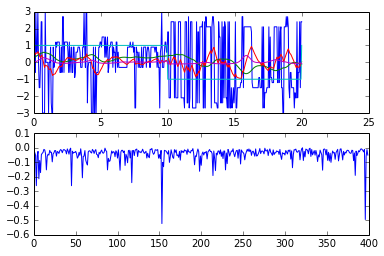

In [133]:
# More initialisation
control = 0
state = np.array([model_Dem, 0.0, model_Dem])
last_observation = np.zeros(controlbatch*observation_ind)
rstate = 0
experiencelog = deque()
improvement = deque()
new_observation = state
new_observationC = np.array([])
mapped_action = np.floor(output_size/2)+1
tv = []
controls = []
error = 0
cheat = time_ox
randomflag = 0
randomcount = 0
fig, axes = plt.subplots()

mpexxx = np.array([0])
mpexxx2 = np.array([0])

# Some logging to check live action scores
ass = np.array([])
tass = ass
ass2 = ass
tass2 = ass

for time_oxx in count():
    time_ox = time_oxx + 1 + cheat
    
    # e-greedy control
    if time_ox <= exploration_period:
        exploration_p =  1#random_action_probability
    else:
        exploration_p = 0.05#np.max([random_action_probability-np.float((time_ox-exploration_period))/1000000, emin])
        
    if (time_ox % target_reset)==0:
        # 'Deep' copy
        #print "Reset"
        #print Layer3.eval()[0]
        #print TLayer3.eval()[0]
        session.run(copy_L1)
        session.run(copy_L2)
        session.run(copy_L3)
        #session.run(tf.initialize_variables([discount_rate]))
        #print Layer3.eval()[0]
        #print TLayer3.eval()[0]
        
    time = time + dt
    tv.append(time)
    
    # Saving previous step
    last_action = mapped_action
    
    ## ----------------------------------------------------------------
    ## INTERCHANGABLE MODEL
    ## ----------------------------------------------------------------
    # Model & Simulation
    dydx = np.zeros_like(state)
    dydx[0] = state[1]
    accel = (-model_K*state[0] - model_C*state[1]) / M1
    dydx[1] = (accel + control) /M1
    dydx[2] = 0
    #dydx[3] = 0
    target = model_Dem * signal.square(2 * np.pi * model_f * time)
    
    state = state + dydx * dt
    #state[2] = accel
    state[2] = target
    
    # Collecting reward
    preverror = error
    error = state[0]-target
    
    reward = 1.0/np.cosh(4*error) - 0.1 #+  np.sign(error-preverror)
    
    ## ----------------------------------------------------------------
    
    # Collecting together data for an observation
    new_observation = state
    
    experiencelog.append((last_observation, last_action, reward, new_observation, target))
    controls.append(control)
    
    if randomcount >= randommax:
        randomflag = 0
        randomcount = 0
        
    if (time_ox % (controlbatch))!=0:
        new_observationC = np.append(new_observationC,new_observation)
    else:
        new_observationC = np.append(new_observationC,new_observation)
        if randomflag == 0:
            if (random.random() < exploration_p) | (len(experience)<exploration_period):
                new_action = random.randint(0, output_size - 1)
                randomcount = 0
                randomflag = 1
            else:
                new_actions, ass, tass = session.run( # Selecting control value
                    [predicted_actions,
                    action_scores,
                    Taction_scores],
                    {observation: [new_observationC], next_observation: [new_observationC]}
                 )
                new_action = new_actions[0]
        else:
            randomcount += 1
        
        # Making a zero output correspond to the most zero action
        mapped_action = (new_action + output_size/2) % output_size
        control = C[mapped_action]

        # Training
        if len(experience) >= exploration_period:
            samples = random.sample(range(len(experience)), minibatch_size)
            samples = [experience[i] for i in samples]

            Xobservation = np.empty((len(samples), observation_size))
            Xnewobservation = np.empty((len(samples), observation_size))
            Xaction_mask = np.zeros((len(samples), output_size))
            Xrewards = np.zeros((len(samples),))

            for i, (x_observation, x_action, x_reward, x_newobservation) in enumerate(samples):
                Xobservation[i] = x_observation
                Xaction_mask[i][x_action] = 1
                Xrewards[i] = x_reward
                Xnewobservation[i] = x_newobservation
            
            mpexxx = session.run([
                prediction_error,
            ], { 
                observation: Xobservation,
                next_observation: Xnewobservation,
                action_mask: Xaction_mask,
                rewards: Xrewards,
            })
            
            _, summary, ascores = session.run([
                train_op,
                merged,
                action_scores,
            ], { 
                observation: Xobservation,
                next_observation: Xnewobservation,
                action_mask: Xaction_mask,
                rewards: Xrewards,
            })
            
            mpexxx2 = session.run([
                prediction_error,
            ], { 
                observation: Xobservation,
                next_observation: Xnewobservation,
                action_mask: Xaction_mask,
                rewards: Xrewards,
            })
            
            improvement.append((np.sum(mpexxx2[0] - mpexxx[0])))
            # Add to tensorboard
            writer.add_summary(summary, time_oxx)
    
            # Hunting down NaNs
            temp = Layer3.eval()
            if np.isnan(temp).any():
                print np.isnan(Xobservation)
                print np.isnan(Xnewobservation)
                print np.isnan(Xaction_mask)
                print np.isnan(Xrewards)
                break            
        
        # Collecting experience
        experience.append((last_observation, last_action, reward, new_observationC)) # Switched to last action for a logical set of data
            
        if len(experience) > max_experience:
            experience.popleft()
        
        # Re-freshing        
        last_observation = new_observationC # Reset last observation now that it has been added to experience
        new_observationC = np.array([])
        
    # End of optimization
    if episodes == episode_max:
        break
            
    if time > tepisode_max:
        
        # Plotting every X episodes
        
        states = [row[3] for row in experiencelog]
        tgt = [row[4] for row in experiencelog]
        x = [row[0] for row in states]
        v = [row[1] for row in states]
        rew = [row[2] for row in experiencelog]
        rewardsTotal = sum([row[2] for row in experiencelog])
        improvements = [row for row in improvement]
        if (episodes % plot_every) == 0:
            print discount_rate.eval(), episodes, rewardsTotal, exploration_p, np.mean(x)
            print np.concatenate((ass, tass), axis=0)
            #print np.concatenate((ass, ass2), axis=0)
            #print np.concatenate((tass, tass2), axis=0)
            print mpexxx2[0] - mpexxx[0]        
            #print Layer3.eval()[0] - TLayer3.eval()[0]
            
            plt.clf()
            
            ax1 = plt.subplot(2, 1, 1)
            ax1.plot(tv,controls)
            ax1.plot(tv, x)
            ax1.plot(tv, v)
            ax1.plot(tv,tgt)
            ax1.plot(tv,rew)
            
            ax2 = plt.subplot(2, 1, 2)
            ax2.plot(improvements)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            timelib.sleep(0.1)
            
        # Resetting for next episode
        #state = np.array([model_Dem, 0.0, model_Dem])
        #new_action = np.floor(output_size/2)+1
        #new_observation = state
        controls = []
        time = 0
        tv = []
        episodes = episodes + 1
        experiencelog = deque()
        improvement = deque()

In [130]:
saver = tf.train.Saver()
save_path = os.path.join(startPath,'Models','SquareWaveDemandSpringMassDamper4.ckpt')
saver.save(session, save_path)
print("Model saved in file: %s" % save_path)

Model saved in file: /Users/davidbrowne/TensorFlowReinforcementLearning/Models/SquareWaveDemandSpringMassDamper4.ckpt


In [ ]:
temp1, temp2, temp3 = session.run([masked_action_scores, future_rewards, gradients], { 
                observation: Xobservation,
                next_observation: Xnewobservation,
                action_mask: Xaction_mask,
                rewards: Xrewards,
            })

print temp1
print temp2

In [ ]:
Xrewards

In [ ]:
episodes = 0

In [ ]:
[row for row in improvement]